# 04 - Train CodeBERT Baseline Model

This notebook implements the training pipeline for fine-tuning CodeBERT on Solidity smart contract vulnerability detection.

**Objectives:**
- Load pre-trained CodeBERT model and add classification head
- Implement training loop with AdamW optimizer and learning rate scheduler
- Monitor validation F1 score and save best checkpoint
- Save final trained model for inference
- Log training metrics and hyperparameters

**Output:** Trained model checkpoint ready for evaluation

## Setup and Imports

In [1]:
import os
import sys
import json
import pickle
import time
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Data handling
import pandas as pd
import numpy as np
from collections import defaultdict

# PyTorch and transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR

from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AutoConfig,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)

# Metrics and visualization
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Set style and disable warnings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"🚀 Training Environment Setup")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

🚀 Training Environment Setup
PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA RTX 4000 Ada Generation
CUDA version: 12.8
Using device: cuda


## Load Configuration and Datasets

In [2]:
# Load dataset configuration
print("📂 Loading dataset configuration...")

with open('../data/processed/dataset_config.json', 'r') as f:
    config = json.load(f)

MODEL_NAME = config['model_name']
MAX_LENGTH = config['max_length']
BATCH_SIZE = config['batch_size']

print(f"Model: {MODEL_NAME}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")

# Load datasets
print("\n📊 Loading datasets...")
train_df = pd.read_csv('../data/processed/train_functions.csv')
val_df = pd.read_csv('../data/processed/validation_functions.csv')
test_df = pd.read_csv('../data/processed/test_functions.csv')

print(f"Train: {len(train_df):,} samples")
print(f"Validation: {len(val_df):,} samples")
print(f"Test: {len(test_df):,} samples")

# Load label encoder for multiclass
with open('../data/processed/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

print(f"\n🏷️ Label classes: {label_encoder.classes_}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Create output directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../results/checkpoints', exist_ok=True)
os.makedirs('../results/metrics', exist_ok=True)
os.makedirs('../logs', exist_ok=True)

print("\n✅ Configuration loaded successfully!")

📂 Loading dataset configuration...
Model: microsoft/codebert-base
Max sequence length: 512
Batch size: 16

📊 Loading datasets...
Train: 10,032 samples
Validation: 3,344 samples
Test: 3,344 samples

🏷️ Label classes: ['Overflow-Underflow' 'Re-entrancy' 'SAFE' 'TOD' 'Timestamp-Dependency'
 'Unchecked-Send' 'Unhandled-Exceptions' 'tx.origin']
Number of classes: 8

✅ Configuration loaded successfully!


## Define Dataset and Model Classes

In [3]:
class VulnDataset(Dataset):
    """Dataset for vulnerability detection with both binary and multiclass support"""
    
    def __init__(self, dataframe, tokenizer, max_length=512, task='binary'):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.task = task
        
        if task == 'binary':
            self.labels = self.df['is_vulnerable'].astype(int).values
        else:  # multiclass
            self.labels = label_encoder.transform(self.df['vulnerability_category']).astype(int)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get function source code - column name is 'code' not 'source_code'
        text = str(self.df.iloc[idx]['code'])
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


class CodeBERTClassifier(nn.Module):
    """CodeBERT with classification head"""
    
    def __init__(self, model_name, num_classes, dropout=0.1, freeze_base=False):
        super().__init__()
        self.num_classes = num_classes
        
        # Load CodeBERT
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Freeze base model if requested
        if freeze_base:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
        # Initialize classifier weights
        nn.init.normal_(self.classifier.weight, std=0.02)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, input_ids, attention_mask, labels=None, return_attention=False):
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=return_attention,
            return_dict=True
        )
        
        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        
        # Apply dropout and classify
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        result = {'logits': logits}
        
        # Add attention weights if requested
        if return_attention:
            result['attentions'] = outputs.attentions
        
        # Calculate loss if labels provided
        if labels is not None:
            if self.num_classes == 1:  # Binary classification
                loss_fn = nn.BCEWithLogitsLoss()
                loss = loss_fn(logits.view(-1), labels.float())
            else:  # Multiclass
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(logits, labels)
            result['loss'] = loss
        
        return result

print("✅ Dataset and model classes defined!")

✅ Dataset and model classes defined!


## Training Configuration

In [4]:
# Training hyperparameters
TRAINING_CONFIG = {
    # Model settings
    'task': 'binary',  # Change to 'multiclass' for multiclass classification
    'dropout': 0.1,
    'freeze_base': False,  # Set True to freeze CodeBERT base layers
    
    # Training settings
    'epochs': 5,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'warmup_steps': 500,
    'max_grad_norm': 1.0,
    
    # Evaluation and saving
    'eval_steps': 200,  # Evaluate every N steps
    'save_steps': 500,  # Save checkpoint every N steps
    'logging_steps': 50,  # Log metrics every N steps
    'early_stopping_patience': 3,  # Stop if no improvement for N evaluations
    
    # Scheduler
    'scheduler_type': 'linear',  # 'linear', 'cosine', or 'constant'
    
    # Data loading
    'num_workers': 4 if torch.cuda.is_available() else 0,
    'pin_memory': torch.cuda.is_available(),
    
    # Mixed precision training
    'use_amp': torch.cuda.is_available(),  # Automatic Mixed Precision
    
    # For quick testing - set to True to use smaller subset
    'use_subset': False,  # Set to True for quick testing
}

print("⚙️ Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

# Determine number of classes
if TRAINING_CONFIG['task'] == 'binary':
    NUM_CLASSES = 1  # Binary classification uses BCEWithLogitsLoss
else:
    NUM_CLASSES = len(label_encoder.classes_)

print(f"\n🏷️ Task: {TRAINING_CONFIG['task']} ({NUM_CLASSES} {'class' if NUM_CLASSES == 1 else 'classes'})")

# Create timestamp for this training run
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_NAME = f"codebert_{TRAINING_CONFIG['task']}_{TIMESTAMP}"

print(f"🏃 Run name: {RUN_NAME}")

⚙️ Training Configuration:
  task: binary
  dropout: 0.1
  freeze_base: False
  epochs: 5
  learning_rate: 2e-05
  weight_decay: 0.01
  warmup_steps: 500
  max_grad_norm: 1.0
  eval_steps: 200
  save_steps: 500
  logging_steps: 50
  early_stopping_patience: 3
  scheduler_type: linear
  num_workers: 4
  pin_memory: True
  use_amp: True
  use_subset: False

🏷️ Task: binary (1 class)
🏃 Run name: codebert_binary_20251111_002909


## Create Data Loaders

In [5]:
# Load tokenizer
print("🔤 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Use subset for quick testing if enabled
if TRAINING_CONFIG['use_subset']:
    print("⚡ Using subset for quick testing...")
    # Load pre-saved subset
    subset_data = torch.load('../data/processed/subset_datasets.pt')
    train_loader = subset_data['train_subset_loader']
    val_loader = subset_data['val_subset_loader']
    
    print(f"Subset sizes - Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}")
else:
    print("📊 Creating full datasets...")
    
    # Create datasets
    train_dataset = VulnDataset(
        train_df, 
        tokenizer, 
        max_length=MAX_LENGTH, 
        task=TRAINING_CONFIG['task']
    )
    
    val_dataset = VulnDataset(
        val_df, 
        tokenizer, 
        max_length=MAX_LENGTH, 
        task=TRAINING_CONFIG['task']
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=TRAINING_CONFIG['num_workers'],
        pin_memory=TRAINING_CONFIG['pin_memory']
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=TRAINING_CONFIG['num_workers'],
        pin_memory=TRAINING_CONFIG['pin_memory']
    )
    
    print(f"Full sizes - Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}")

print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test data loader
print("\n🧪 Testing data loader...")
sample_batch = next(iter(train_loader))
print(f"Sample batch shapes:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  attention_mask: {sample_batch['attention_mask'].shape}")
print(f"  labels: {sample_batch['labels'].shape}")

print("✅ Data loaders created successfully!")

🔤 Loading tokenizer...
📊 Creating full datasets...
Full sizes - Train: 10032, Val: 3344
Batch size: 16
Train batches: 627
Validation batches: 209

🧪 Testing data loader...
Sample batch shapes:
  input_ids: torch.Size([16, 512])
  attention_mask: torch.Size([16, 512])
  labels: torch.Size([16])
✅ Data loaders created successfully!


## Initialize Model and Training Components

In [6]:
# Initialize model
print(f"🤖 Initializing CodeBERT model...")
model = CodeBERTClassifier(
    model_name=MODEL_NAME,
    num_classes=NUM_CLASSES,
    dropout=TRAINING_CONFIG['dropout'],
    freeze_base=TRAINING_CONFIG['freeze_base']
)

# Move to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model loaded on {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Initialize optimizer
optimizer = AdamW(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

# Calculate total training steps
total_steps = len(train_loader) * TRAINING_CONFIG['epochs']
warmup_steps = TRAINING_CONFIG['warmup_steps']

print(f"\n📅 Training schedule:")
print(f"  Total steps: {total_steps:,}")
print(f"  Warmup steps: {warmup_steps:,}")

# Initialize scheduler
if TRAINING_CONFIG['scheduler_type'] == 'linear':
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
elif TRAINING_CONFIG['scheduler_type'] == 'cosine':
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
else:  # constant
    scheduler = None

print(f"Scheduler: {TRAINING_CONFIG['scheduler_type']}")

# Initialize mixed precision scaler if using AMP
scaler = torch.cuda.amp.GradScaler() if TRAINING_CONFIG['use_amp'] else None
print(f"Mixed precision: {TRAINING_CONFIG['use_amp']}")

print("\n✅ Model and training components initialized!")

🤖 Initializing CodeBERT model...
Model loaded on cuda
Total parameters: 124,646,401
Trainable parameters: 124,646,401

📅 Training schedule:
  Total steps: 3,135
  Warmup steps: 500
Scheduler: linear
Mixed precision: True

✅ Model and training components initialized!


## Training and Evaluation Functions

In [7]:
def calculate_metrics(predictions, labels, task='binary'):
    """Calculate evaluation metrics"""
    if task == 'binary':
        # Convert probabilities to predictions
        preds = (predictions > 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='binary', zero_division=0
        )
        
        try:
            auc = roc_auc_score(labels, predictions)
            avg_precision = average_precision_score(labels, predictions)
        except ValueError:
            auc = 0.0
            avg_precision = 0.0
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'avg_precision': avg_precision
        }
    
    else:  # multiclass
        preds = np.argmax(predictions, axis=1)
        
        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='macro', zero_division=0
        )
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }


def evaluate_model(model, val_loader, device, task='binary'):
    """Evaluate model on validation set"""
    model.eval()
    
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs['loss']
            logits = outputs['logits']
            
            total_loss += loss.item()
            
            # Convert logits to predictions
            if task == 'binary':
                predictions = torch.sigmoid(logits).cpu().numpy().flatten()
            else:
                predictions = torch.softmax(logits, dim=-1).cpu().numpy()
            
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    avg_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    metrics = calculate_metrics(all_predictions, all_labels, task)
    metrics['loss'] = avg_loss
    
    return metrics


def save_checkpoint(model, optimizer, scheduler, epoch, step, metrics, filepath):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'metrics': metrics,
        'config': TRAINING_CONFIG,
        'model_config': {
            'model_name': MODEL_NAME,
            'num_classes': NUM_CLASSES,
            'max_length': MAX_LENGTH
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"💾 Checkpoint saved: {filepath}")


print("✅ Training functions defined!")

✅ Training functions defined!


## Training Loop

In [8]:
# Training tracking
training_stats = {
    'train_losses': [],
    'val_losses': [],
    'val_metrics': [],
    'learning_rates': [],
    'epochs': [],
    'steps': []
}

# Best model tracking
best_f1 = 0.0
best_model_path = f'../results/checkpoints/best_model_{RUN_NAME}.pt'
epochs_without_improvement = 0

# Start training
print(f"🚀 Starting training: {RUN_NAME}")
print(f"Training for {TRAINING_CONFIG['epochs']} epochs...")
print("=" * 60)

global_step = 0
start_time = time.time()

for epoch in range(TRAINING_CONFIG['epochs']):
    print(f"\n📅 Epoch {epoch + 1}/{TRAINING_CONFIG['epochs']}")
    
    # Training phase
    model.train()
    epoch_loss = 0
    
    progress_bar = tqdm(
        train_loader, 
        desc=f"Epoch {epoch + 1}",
        leave=False
    )
    
    for step, batch in enumerate(progress_bar):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass with mixed precision
        if TRAINING_CONFIG['use_amp']:
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs['loss']
        else:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs['loss']
        
        # Backward pass
        if TRAINING_CONFIG['use_amp']:
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), TRAINING_CONFIG['max_grad_norm'])
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), TRAINING_CONFIG['max_grad_norm'])
            
            # Optimizer step
            optimizer.step()
        
        # Scheduler step
        if scheduler:
            scheduler.step()
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Update tracking
        epoch_loss += loss.item()
        global_step += 1
        
        # Update progress bar
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{current_lr:.2e}'
        })
        
        # Log metrics
        if global_step % TRAINING_CONFIG['logging_steps'] == 0:
            training_stats['train_losses'].append(loss.item())
            training_stats['learning_rates'].append(current_lr)
            training_stats['steps'].append(global_step)
        
        # Evaluation
        if global_step % TRAINING_CONFIG['eval_steps'] == 0:
            print(f"\n🔍 Evaluating at step {global_step}...")
            
            val_metrics = evaluate_model(
                model, val_loader, device, TRAINING_CONFIG['task']
            )
            
            # Log validation metrics
            training_stats['val_losses'].append(val_metrics['loss'])
            training_stats['val_metrics'].append(val_metrics)
            
            print(f"Validation metrics:")
            for metric, value in val_metrics.items():
                print(f"  {metric}: {value:.4f}")
            
            # Check for best model
            current_f1 = val_metrics['f1']
            if current_f1 > best_f1:
                best_f1 = current_f1
                epochs_without_improvement = 0
                
                # Save best model
                save_checkpoint(
                    model, optimizer, scheduler, epoch, global_step,
                    val_metrics, best_model_path
                )
                print(f"🎉 New best F1: {best_f1:.4f}")
            else:
                epochs_without_improvement += 1
            
            model.train()  # Switch back to training mode
        
        # Save checkpoint
        if global_step % TRAINING_CONFIG['save_steps'] == 0:
            checkpoint_path = f"../results/checkpoints/checkpoint_{RUN_NAME}_step_{global_step}.pt"
            save_checkpoint(
                model, optimizer, scheduler, epoch, global_step,
                val_metrics if 'val_metrics' in locals() else {},
                checkpoint_path
            )
    
    # End of epoch summary
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"\n📊 Epoch {epoch + 1} Summary:")
    print(f"  Average loss: {avg_epoch_loss:.4f}")
    print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Early stopping check
    if epochs_without_improvement >= TRAINING_CONFIG['early_stopping_patience']:
        print(f"\n⏰ Early stopping triggered after {epochs_without_improvement} epochs without improvement")
        break

# Training complete
total_time = time.time() - start_time
print(f"\n🏁 Training completed!")
print(f"Total time: {total_time / 60:.1f} minutes")
print(f"Best F1 score: {best_f1:.4f}")
print(f"Best model saved: {best_model_path}")

🚀 Starting training: codebert_binary_20251111_002909
Training for 5 epochs...

📅 Epoch 1/5


Epoch 1:   0%|          | 0/627 [00:00<?, ?it/s]


🔍 Evaluating at step 200...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9366
  precision: 0.0000
  recall: 0.0000
  f1: 0.0000
  auc: 0.7568
  avg_precision: 0.3468
  loss: 0.2231

🔍 Evaluating at step 400...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9387
  precision: 0.5347
  recall: 0.2547
  f1: 0.3450
  auc: 0.7523
  avg_precision: 0.4009
  loss: 0.1929
💾 Checkpoint saved: ../results/checkpoints/best_model_codebert_binary_20251111_002909.pt
🎉 New best F1: 0.3450
💾 Checkpoint saved: ../results/checkpoints/checkpoint_codebert_binary_20251111_002909_step_500.pt

🔍 Evaluating at step 600...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9462
  precision: 0.7667
  recall: 0.2170
  f1: 0.3382
  auc: 0.7844
  avg_precision: 0.4372
  loss: 0.1848

📊 Epoch 1 Summary:
  Average loss: 0.2211
  Learning rate: 1.90e-05

📅 Epoch 2/5


Epoch 2:   0%|          | 0/627 [00:00<?, ?it/s]


🔍 Evaluating at step 800...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9498
  precision: 0.6833
  recall: 0.3868
  f1: 0.4940
  auc: 0.8155
  avg_precision: 0.5005
  loss: 0.1954
💾 Checkpoint saved: ../results/checkpoints/best_model_codebert_binary_20251111_002909.pt
🎉 New best F1: 0.4940

🔍 Evaluating at step 1000...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9444
  precision: 0.5903
  recall: 0.4009
  f1: 0.4775
  auc: 0.8131
  avg_precision: 0.4779
  loss: 0.1797
💾 Checkpoint saved: ../results/checkpoints/checkpoint_codebert_binary_20251111_002909_step_1000.pt

🔍 Evaluating at step 1200...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9474
  precision: 0.9286
  recall: 0.1840
  f1: 0.3071
  auc: 0.8087
  avg_precision: 0.5097
  loss: 0.2225

📊 Epoch 2 Summary:
  Average loss: 0.1717
  Learning rate: 1.43e-05

📅 Epoch 3/5


Epoch 3:   0%|          | 0/627 [00:00<?, ?it/s]


🔍 Evaluating at step 1400...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9507
  precision: 0.8615
  recall: 0.2642
  f1: 0.4043
  auc: 0.8125
  avg_precision: 0.5154
  loss: 0.1844
💾 Checkpoint saved: ../results/checkpoints/checkpoint_codebert_binary_20251111_002909_step_1500.pt

🔍 Evaluating at step 1600...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3136db22a0>
Traceback (most recent call last):
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/netweb/vasu/smart-contract-vuln-detector/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/netweb/.pyenv/versions/3.11.14/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation metrics:
  accuracy: 0.9513
  precision: 0.7379
  recall: 0.3585
  f1: 0.4825
  auc: 0.8224
  avg_precision: 0.5133
  loss: 0.1960

🔍 Evaluating at step 1800...


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

Validation metrics:
  accuracy: 0.9501
  precision: 0.8571
  recall: 0.2547
  f1: 0.3927
  auc: 0.8273
  avg_precision: 0.5315
  loss: 0.1921

📊 Epoch 3 Summary:
  Average loss: 0.1556
  Learning rate: 9.52e-06

⏰ Early stopping triggered after 5 epochs without improvement

🏁 Training completed!
Total time: 13.1 minutes
Best F1 score: 0.4940
Best model saved: ../results/checkpoints/best_model_codebert_binary_20251111_002909.pt


## Final Model Evaluation and Saving

In [9]:
# Load best model for final evaluation
print("🔄 Loading best model for final evaluation...")
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Final validation evaluation
print("\n📊 Final validation evaluation:")
final_val_metrics = evaluate_model(model, val_loader, device, TRAINING_CONFIG['task'])

for metric, value in final_val_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Save final model (state dict only, for inference)
final_model_path = f"../models/codebert_final_{TRAINING_CONFIG['task']}_{TIMESTAMP}.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'model_name': MODEL_NAME,
        'num_classes': NUM_CLASSES,
        'max_length': MAX_LENGTH,
        'task': TRAINING_CONFIG['task']
    },
    'training_config': TRAINING_CONFIG,
    'final_metrics': final_val_metrics,
    'tokenizer_name': MODEL_NAME
}, final_model_path)

print(f"\n💾 Final model saved: {final_model_path}")

# Save training history
training_history_path = f"../results/metrics/training_history_{RUN_NAME}.json"
with open(training_history_path, 'w') as f:
    # Convert numpy types to Python native types for JSON serialization
    history_json = {}
    for key, value in training_stats.items():
        if isinstance(value, list) and len(value) > 0:
            if isinstance(value[0], dict):
                history_json[key] = [
                    {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                     for k, v in item.items()} 
                    for item in value
                ]
            else:
                history_json[key] = [
                    float(x) if isinstance(x, (np.floating, np.integer)) else x 
                    for x in value
                ]
        else:
            history_json[key] = value
    
    json.dump(history_json, f, indent=2)

print(f"📈 Training history saved: {training_history_path}")

print("\n✅ Training pipeline completed successfully!")

🔄 Loading best model for final evaluation...

📊 Final validation evaluation:


Evaluating:   0%|          | 0/209 [00:00<?, ?it/s]

  accuracy: 0.9498
  precision: 0.6833
  recall: 0.3868
  f1: 0.4940
  auc: 0.8155
  avg_precision: 0.5005
  loss: 0.1954

💾 Final model saved: ../models/codebert_final_binary_20251111_002909.pt
📈 Training history saved: ../results/metrics/training_history_codebert_binary_20251111_002909.json

✅ Training pipeline completed successfully!


## Training Visualization

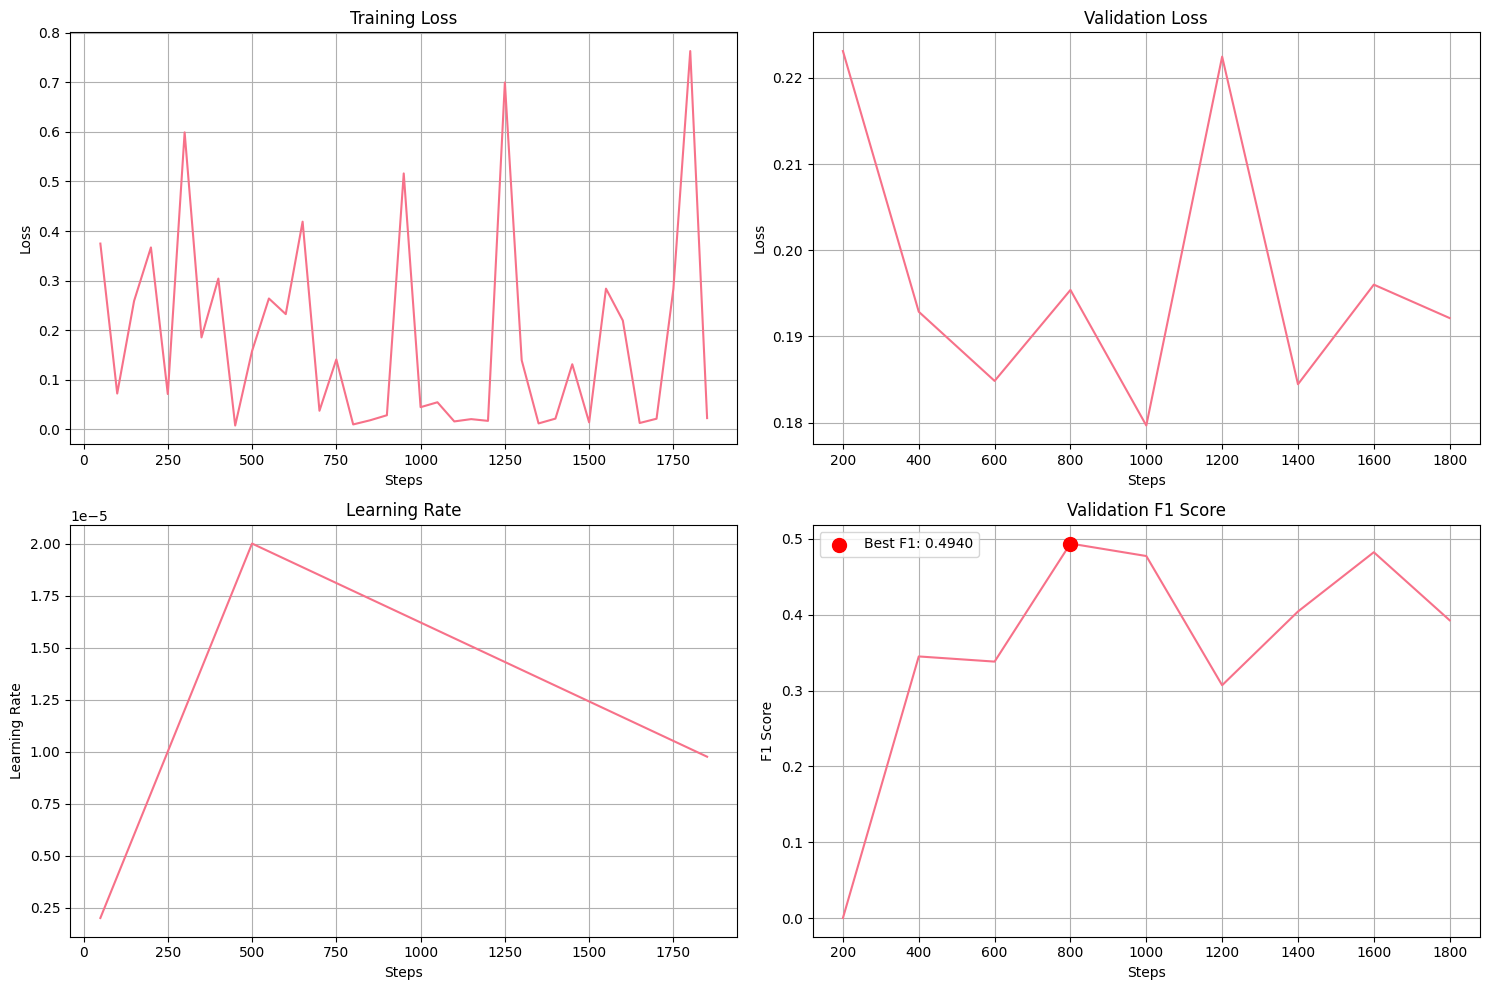

📊 Training curves saved: ../results/visualizations/training_curves_codebert_binary_20251111_002909.png


In [10]:
# Create training visualization
if len(training_stats['train_losses']) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training loss
    if training_stats['train_losses']:
        axes[0, 0].plot(training_stats['steps'], training_stats['train_losses'])
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Steps')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].grid(True)
    
    # Validation loss
    if training_stats['val_losses']:
        eval_steps = list(range(TRAINING_CONFIG['eval_steps'], 
                               len(training_stats['val_losses']) * TRAINING_CONFIG['eval_steps'] + 1, 
                               TRAINING_CONFIG['eval_steps']))
        axes[0, 1].plot(eval_steps, training_stats['val_losses'])
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].set_xlabel('Steps')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].grid(True)
    
    # Learning rate
    if training_stats['learning_rates']:
        axes[1, 0].plot(training_stats['steps'], training_stats['learning_rates'])
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Steps')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].grid(True)
    
    # Validation F1 score
    if training_stats['val_metrics']:
        f1_scores = [m['f1'] for m in training_stats['val_metrics']]
        eval_steps = list(range(TRAINING_CONFIG['eval_steps'], 
                               len(f1_scores) * TRAINING_CONFIG['eval_steps'] + 1, 
                               TRAINING_CONFIG['eval_steps']))
        axes[1, 1].plot(eval_steps, f1_scores)
        axes[1, 1].set_title('Validation F1 Score')
        axes[1, 1].set_xlabel('Steps')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].grid(True)
        
        # Mark best F1
        best_idx = np.argmax(f1_scores)
        axes[1, 1].scatter(eval_steps[best_idx], f1_scores[best_idx], 
                          color='red', s=100, zorder=5, label=f'Best F1: {best_f1:.4f}')
        axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save plot
    plot_path = f"../results/visualizations/training_curves_{RUN_NAME}.png"
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Training curves saved: {plot_path}")
else:
    print("⚠️ No training data to visualize")

## Summary and Next Steps

In [11]:
# Create comprehensive summary
summary = {
    'run_info': {
        'run_name': RUN_NAME,
        'timestamp': TIMESTAMP,
        'task': TRAINING_CONFIG['task'],
        'model_name': MODEL_NAME,
        'device': str(device)
    },
    'data_info': {
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'batch_size': BATCH_SIZE,
        'max_length': MAX_LENGTH,
        'num_classes': NUM_CLASSES
    },
    'training_config': TRAINING_CONFIG,
    'model_info': {
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
    },
    'results': {
        'best_f1': best_f1,
        'final_metrics': final_val_metrics,
        'training_time_minutes': total_time / 60,
        'total_steps': global_step
    },
    'file_paths': {
        'best_model': best_model_path,
        'final_model': final_model_path,
        'training_history': training_history_path
    }
}

# Save summary
summary_path = f"../results/metrics/training_summary_{RUN_NAME}.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print("🎉 TRAINING COMPLETE!")
print("=" * 50)
print(f"\n📊 Training Summary:")
print(f"  Run: {RUN_NAME}")
print(f"  Task: {TRAINING_CONFIG['task']} classification")
print(f"  Model: {MODEL_NAME}")
print(f"  Training time: {total_time / 60:.1f} minutes")
print(f"  Total steps: {global_step:,}")
print(f"  Best F1 score: {best_f1:.4f}")

print(f"\n💾 Output Files:")
print(f"  Best model: {best_model_path}")
print(f"  Final model: {final_model_path}")
print(f"  Training history: {training_history_path}")
print(f"  Summary: {summary_path}")

print(f"\n🚀 Next Steps:")
print(f"  1. Run comprehensive evaluation: 05_evaluation_and_metrics.ipynb")
print(f"  2. Create attention visualizations: 06_attention_visualization.ipynb")
print(f"  3. Benchmark against Slither/Mythril: 07_benchmark_vs_slither_mythril.ipynb")

print(f"\n💡 Usage Example for Loading Trained Model:")
print(f"```python")
print(f"import torch")
print(f"from transformers import AutoTokenizer")
print(f"")
print(f"# Load tokenizer")
print(f"tokenizer = AutoTokenizer.from_pretrained('{MODEL_NAME}')")
print(f"")
print(f"# Load model")
print(f"checkpoint = torch.load('{final_model_path}')")
print(f"model = CodeBERTClassifier(")
print(f"    model_name='{MODEL_NAME}',")
print(f"    num_classes={NUM_CLASSES}")
print(f")")
print(f"model.load_state_dict(checkpoint['model_state_dict'])")
print(f"model.eval()")
print(f"```")

🎉 TRAINING COMPLETE!

📊 Training Summary:
  Run: codebert_binary_20251111_002909
  Task: binary classification
  Model: microsoft/codebert-base
  Training time: 13.1 minutes
  Total steps: 1,881
  Best F1 score: 0.4940

💾 Output Files:
  Best model: ../results/checkpoints/best_model_codebert_binary_20251111_002909.pt
  Final model: ../models/codebert_final_binary_20251111_002909.pt
  Training history: ../results/metrics/training_history_codebert_binary_20251111_002909.json
  Summary: ../results/metrics/training_summary_codebert_binary_20251111_002909.json

🚀 Next Steps:
  1. Run comprehensive evaluation: 05_evaluation_and_metrics.ipynb
  2. Create attention visualizations: 06_attention_visualization.ipynb
  3. Benchmark against Slither/Mythril: 07_benchmark_vs_slither_mythril.ipynb

💡 Usage Example for Loading Trained Model:
```python
import torch
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')

# Load model
